Trying to work with both faces and meta-data

In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from helpers.data_loading import *
from helpers.CNN_layers import ConvLayer, DenseLayer
from spearman import score_function

We first load the extracted faces and the meta features

In [2]:
# faces, _ = load_faces(verbose=False)
# faces_to_predict = faces[10000:13000]  # for final submission
# faces = faces[0:10000]  # training and testing faces

We then load the meta-features

In [3]:
meta, _ = load_meta_features(file="data/facial_features_train.csv")
meta_to_predict, _ = load_meta_features(file="data/facial_features_test.csv")  # for final submission

In [4]:
# here we remove the features that are only available for the train
to_keep = list(set(meta.columns).intersection(set(meta_to_predict.columns)))
to_keep.sort()  # sort in alphabetical order to always have the same order

In [5]:
meta = meta[to_keep]
meta_to_predict = meta_to_predict[to_keep]
# now we remove non-numerical features
numeric_features = np.array([type(value) is not str for value in meta.as_matrix()[0,:]])

In [6]:
meta = meta.as_matrix()[:,numeric_features]
meta_to_predict = meta_to_predict.as_matrix()[:,numeric_features]

In [7]:
meta = np.array(meta, dtype=np.float32)
meta_to_predict = np.array(meta_to_predict, dtype=np.float32)

In [8]:
y, _ = load_labels()  # scores between 0 and 25 for training instances
y = y.reshape((-1,1))

## Building a CNN with meta features connected at the dense layers

We now would like to build a network that allows using both the faces and the meta-features. We thus using a CNN on the faces that ends with one or two dense layers and connect the meta-features at the dense layers level.

![Architecture](report/latex/img/network.svg)

In [67]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True
sess = tf.InteractiveSession(config=config)

In [68]:
n_faces_pixels = 10**4
n_meta = meta.shape[1]
print "Face pixels:\t", n_faces_pixels
print "Meta features:\t", n_meta

Face pixels:	10000
Meta features:	93


We use the layer objects from **helpers.CNN_layers** to build our network.

In [69]:
input_tf = tf.placeholder(tf.float32, shape=[None,100,100,3])
y_tf = tf.placeholder(tf.float32, shape=[None, 1])

conv1 = ConvLayer(input_tf, 32)
conv1.max_pool()

conv2 = ConvLayer(conv1.output, 32)
conv2.max_pool()

fc1 = DenseLayer(conv2.output, 1024)
fc1.drop_out()

meta_tf = tf.placeholder(tf.float32, shape=[None, n_meta])
metaLayer = DenseLayer(meta_tf, 256)

merging_matrix = tf.concat(1, [metaLayer.output, fc1.output])
merge_layer = DenseLayer(merging_matrix, 100)

fc2 = DenseLayer(merge_layer.output, 1)
final_output = fc2.output

The loss we use is the **Mean Square Error** (MSE) with a **L2-regularization** term

In [70]:
mse = (
    tf.reduce_mean((final_output - y_tf)**2) + 0.01*(
        tf.nn.l2_loss(conv1.W) +
        tf.nn.l2_loss(conv2.W) +
        tf.nn.l2_loss(fc1.W) +
        tf.nn.l2_loss(fc2.W) + 
        tf.nn.l2_loss(metaLayer.W) + 
        tf.nn.l2_loss(merge_layer.W)
    )
)
learning_rate = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(learning_rate).minimize(mse)

In [71]:
sess.run(tf.global_variables_initializer())

In [72]:
mse.eval(feed_dict={input_tf:X_test, meta_tf:meta_test, fc1.keep_prob: 1.0, y_tf:y_test})

878.33051

It's easier to work with **generators** and to nest our code a bit using functions.

In [73]:
# sample train/test indices
train = np.arange(1, 9501)
test = np.arange(9501, 10001)

# generators for the batches
def batch_generator(train_or_test, batch_size=50, black_white=True, random_flip=False):
    nb_batch = len(train) // batch_size
    while 1:
        for i in range(nb_batch):
            in_batch = train_or_test[i*batch_size:((i+1)*batch_size)]
            X_batch, _ = faces_batch(in_batch, black_white=black_white)
            meta_batch = meta[in_batch-1, :]  # WARNING meta is indexed from 0!!!
            y_batch = y[in_batch-1]  # WARNING Y is indexed from 0!!!
            y_batch = y_batch.astype(np.float32)
            if random_flip and np.random.rand() > 0.5:
                # with proba 0.5 we flip the face
                X_batch = X_batch[:, :, ::-1, :]
            yield X_batch/255., y_batch, meta_batch
            
# instatiate one generator for train and one for test
train_gen = batch_generator(train, 100, black_white=False, random_flip=True)
test_gen = batch_generator(test, 300, black_white=False)

X_test, y_test, meta_test = next(test_gen)
print X_test.shape
print y_test.shape
print meta_test.shape

(300, 100, 100, 3)
(300, 1)
(300, 93)


In [74]:
# function to run one epoch
def epoch(lr=1e-4):
    X_train, y_train, meta_train = next(train_gen)
    train_step.run(feed_dict={
        input_tf: X_train, 
        meta_tf: meta_train,
        y_tf: y_train,
        fc1.keep_prob: 1.,
        learning_rate: lr
    })
    train_mse = sess.run(mse, feed_dict={input_tf:X_train, y_tf: y_train, meta_tf:meta_train, fc1.keep_prob: 1.0})
    
    # preds on test
    [preds, test_mse] = sess.run([final_output, mse], 
                                 feed_dict={input_tf: X_test, meta_tf: meta_test, fc1.keep_prob: 1.0, y_tf:y_test})
    
    current_spearman = score_function(y_pred=np.round(preds), y_true=y_test)
    
    return {"train_mse":train_mse, "test_mse":test_mse, "test_spearman":current_spearman, 'lr': lr}

In [75]:
# history of the loss through iterations
learning_history = {'iterations':[], 'train_mse':[], 'test_mse':[], 'test_spearman':[], 'lr':[]}

def update_history(learning_history, epoch):
    learning_history['iterations'].append(len(learning_history['iterations']))
    for name in ['train_mse', 'test_mse', 'test_spearman', 'lr']:
        learning_history[name].append(epoch[name])

i=999


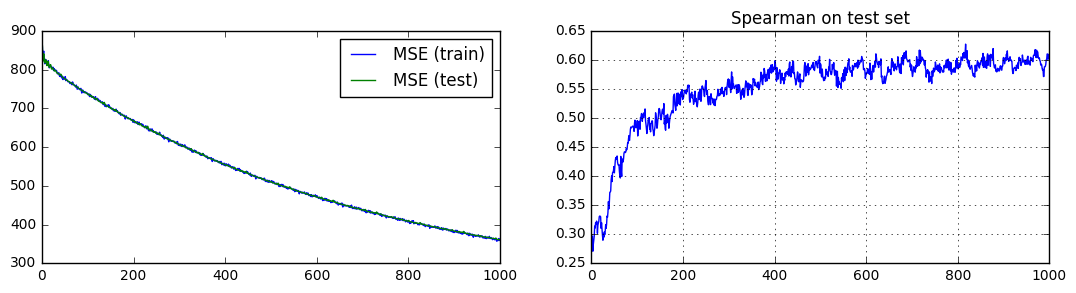

In [76]:
window = 1000  # plot only last x iterations
refresh = 20  # refresh every x iterations
for i in range(1000):
    update_history(learning_history, epoch(lr=10**-4))
    if (i+1) % refresh == 0:
        clear_output()
        print "i=%i"%i
        f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        axarr[0].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['train_mse'][:-window:-1][::-1], label="MSE (train)")
        axarr[0].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['test_mse'][:-window:-1][::-1], label="MSE (test)")
        axarr[1].plot(learning_history['iterations'][:-window:-1][::-1], learning_history['test_spearman'][:-window:-1][::-1], label="Spearman (test)")
        axarr[0].legend()
        axarr[1].set_title("Spearman on test set")
        axarr[1].grid()
        plt.show()

## Making a quick submission

In [86]:
X_to_predict, ids_to_predict = faces_batch(np.arange(10001, 13001), black_white=False)
X_to_predict = X_to_predict/255.
final_predictions = np.array([])
for i in range(0, 30):
    mini_batch = np.arange(i*100, (i+1)*100)
    final_predictions = np.append(final_predictions, final_output.eval(feed_dict={
        input_tf: X_to_predict[mini_batch], meta_tf: meta_to_predict[mini_batch], fc1.keep_prob: 1.0}).flatten()
    )

In [89]:
export_submission(final_predictions, "CNN_faces_meta")  # 0.534 after submission